<a href="https://colab.research.google.com/github/jjfj2011/Bot-de-trading-automatizado-para-Bitcoin/blob/main/Trading_bot_24hrs_Proyecto_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bot de trading automatizado para Bitcoin**

# 1. Configuración del Ambiente


In [ ]:
# Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False) # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5)) # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

# Configurar pandas para mostrar todos los dígitos
pd.options.display.float_format = '{:.1f}'.format

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

In [ ]:
#Muestra versiones de las bibliotecas
# Verificar la versión de Python
!python --version

# Verificar la versión de pandas
!pip show pandas | grep Version

# Verificar la versión de numpy
!pip show numpy | grep Version

# Verificar la versión de matplotlib
!pip show matplotlib | grep Version

Python 3.11.11
Version: 2.2.2
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Version: 3.10.0


# 2. Obtención de datos

## 2.1 Precios Históricos del Bitcoin

In [ ]:
def importar_base_bitcoin():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

  end_date = datetime.now()
  start_date = end_date - timedelta(days=7)

  # Descargar datos de Bitcoin usando yfinance
  df_bitcoin = yf.download(
      tickers="BTC-USD",
      start=start_date.strftime('%Y-%m-%d'),
      end=end_date.strftime('%Y-%m-%d'),
      interval="5m")

  # Verificar que tenemos suficientes datos
  if df_bitcoin.empty:
    raise ValueError("No se pudieron obtener datos de Bitcoin")

  # Aplanar las columnas MultiIndex y renombrarlas
  df_bitcoin.columns = [col[0] for col in df_bitcoin.columns] # Tomar solo el primer nivel de las columnas

  # Reordenar las columnas
  df_bitcoin = df_bitcoin[["Open", "High", "Low", "Close", "Volume"]]

In [ ]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2025-01-18 00:00:00+00:00,104114.4,104172.5,104114.4,104140.0,0
2025-01-18 00:05:00+00:00,104237.4,104336.5,104237.4,104336.5,41443328
2025-01-18 00:10:00+00:00,104319.3,104382.6,104319.3,104352.5,68100096
2025-01-18 00:15:00+00:00,104369.6,104455.8,104369.6,104450.2,0
2025-01-18 00:20:00+00:00,104338.6,104338.6,104318.6,104318.6,0


## 2.2 Indicadores de Tendencias

# ATENCIÓN
# Los selectores HTML pueden variar según las actualizaciones del sitio web, así que si el scraping no funciona
# revisen la estructura actualizada del HTML.

In [ ]:
def extraer_tendencias():
  global precio_actual, tendencia, color

  # Definir los headers para evitar que se detecte como un bot
  headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1'
    }

  # URL de la página
  url = "https://coinmarketcap.com/currencies/bitcoin/"

  try:
    # Realizar la solicitud HTTP
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
      # Analizar el contenido HTML
      soup = BeautifulSoup(response.content, 'html.parser')

      # Buscar el precio de Bitcoin
      precio_elemento = soup.find('span', {"data-test":"text-cdp-price-display"})
      if precio_elemento:
        precio_actual = precio_elemento.text.strip()  # Limpiar el texto extraído
        # print(f"Precio actual de Bitcoin: {precio_actual}")
      else:
        print("No se pudo encontrar el precio actual.")


      # Buscar la tendencia de Bitcoin
      tendencia_elemento = soup.find('p', class_='sc-71024e3e-0 sc-8ec8b63a-1 bgxfSG icQYnE change-text', attrs={"color": True, "data-change": True})
      # tendencia_elemento = soup.find('p', class_='sc-71024e3e-0 sc-8ec8b63a-1 ihXFUo icQYnE change-text', attrs={"color": True, "data-change": True})

      # Determinar si es "ALTA" o "BAJA"
      if tendencia_elemento:
        color = tendencia_elemento['color']
        if color == "green":
          tendencia = 'alta'  # Tendencia alcista
        elif color == "red":
          tendencia = 'baja'  # Tendencia bajista
        else:
          tendencia = None
      else:
        tendencia = None

      # Mostrar el resultado
      # print(f"Tendencia: {tendencia}")

  except requests.exceptions.RequestException as e:
    print(f'Error al hacer la solicitud: {e}')

In [ ]:
extraer_tendencias()
print(f"Precio actual de Bitcoin: {precio_actual}")
print(f"Tendencia: {tendencia}")

Precio actual de Bitcoin: $104,678.61
Tendencia: alta


# 3. Limpieza de datos

## 3.1 Exploración inicial de los datos de Bitcoin sin tratamiento

In [ ]:
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 2025-01-18 00:00:00+00:00 to 2025-01-24 21:55:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1992 non-null   float64
 1   High    1992 non-null   float64
 2   Low     1992 non-null   float64
 3   Close   1992 non-null   float64
 4   Volume  1992 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 93.4 KB
None


,Open,High,Low,Close,Volume
count,1992.0,1992.0,1992.0,1992.0,1992.0
mean,104266.0,104352.0,104183.0,104271.0,92395522.0
std,1602.0,1596.0,1604.0,1597.0,242280478.0
min,99623.0,99941.0,99623.0,99722.0,0.0
25%,103199.0,103265.0,103119.0,103188.0,0.0
50%,104342.0,104411.0,104295.0,104352.0,0.0
75%,105240.0,105306.0,105162.0,105251.0,83703808.0
max,108900.0,109110.0,108711.0,108897.0,3901677568.0


## 3.2 Visualización de la distribución del Precio de Cierre sin tratamiento

<Axes: >

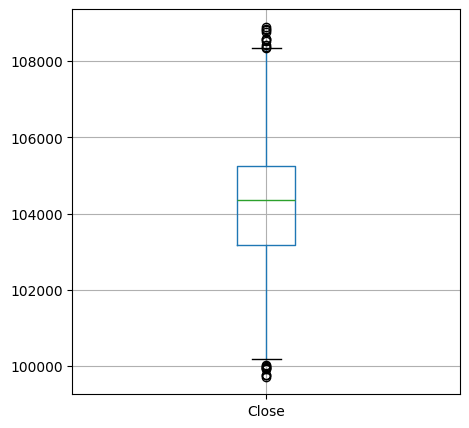

In [ ]:
#Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close'])

## 3.3 Función para la limpieza de los datos de Bitcoin

In [ ]:
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin, precio_actual, tendencia

    # Número inicial de datos
    num_datos_inicial = df_bitcoin.shape[0]
    print(f"Número inicial de datos: {num_datos_inicial}")

    # Copiar el DataFrame original para no modificarlo directamente
    df_bitcoin_limpio = df_bitcoin.copy()

    # Paso 1: Eliminar los índices duplicados
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
    print(f"Duplicados eliminados: {num_datos_inicial - df_bitcoin_limpio.shape[0]}")

    # Paso 2: Rellenar valores nulos en la columna 'Close con el último valor válido
    df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].ffill()

    # Eliminación de filas con volumen menor o igual a cero:
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # Cálculo del rango intercuartil (IQR)
    Q1 = np.quantile(df_bitcoin_limpio['Close'], 0.25)
    Q3 = np.quantile(df_bitcoin_limpio['Close'], 0.75)
    IQR = Q3 - Q1
    print(f'Límites de eliminación de outliers: Inferior={Q1 - 1.5*IQR}, Superior={Q3 + 1.5*IQR}')

    # Eliminación de Outliers
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= (Q1 - 1.5*IQR)) & (df_bitcoin_limpio['Close'] <= (Q3 + 1.5*IQR))]

    # Cálculo del precio promedio de Bitcoin después de la limpieza
    media_bitcoin = df_bitcoin_limpio['Close'].mean()

    # Número final de datos
    # print(f"Número de registros antes de la limpieza: {df_bitcoin.shape[0]}")
    print(f"Número final de datos: {df_bitcoin_limpio.shape[0]}")
    print(f"Datos eliminados durante la limpieza: {df_bitcoin.shape[0] - df_bitcoin_limpio.shape[0]}")

## 3.4 Visualización de la distribución del Precio de Cierre después de la limpieza

Número inicial de datos: 1992
Duplicados eliminados: 0
Límites de eliminación de outliers: Inferior=98764.73828125, Superior=108898.51953125
Número final de datos: 893
Datos eliminados durante la limpieza: 1099


<Axes: >

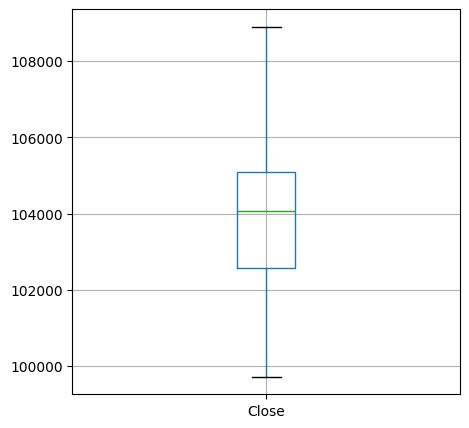

In [ ]:
limpieza_datos()
# Muestra el Boxplot de la base limpia

df_bitcoin_limpio.boxplot(['Close'], showfliers=False)

## 3.5 Comparación de la distribución del Precio de Cierre antes y después de la limpieza

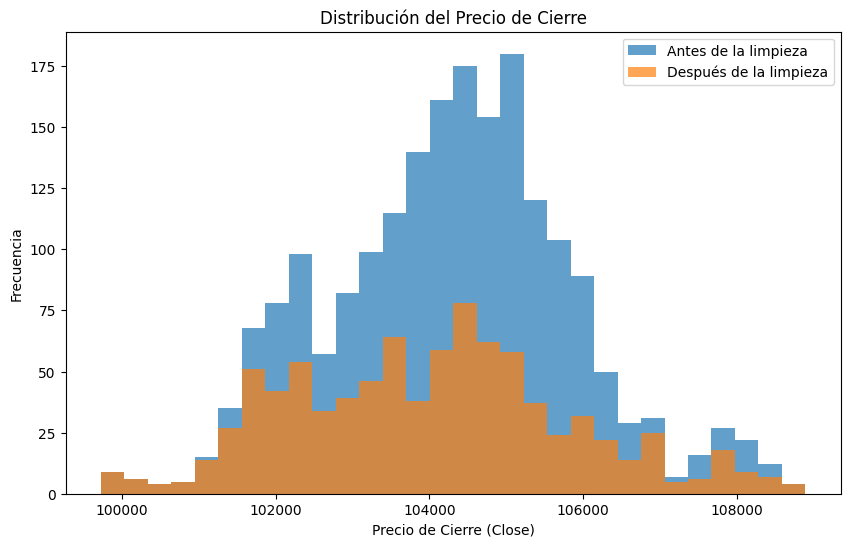

In [ ]:
#@title Gráfico de distribución del Precio de Cierre antes y después de la limpieza { display-mode: "form" }
# Gráfico de antes y después de la limpieza de la distribución del Precio de Cierre
plt.figure(figsize=(10,6))
plt.hist(df_bitcoin['Close'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close'], bins=30, alpha=0.7, label='Después de la limpieza')
plt.legend()
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre (Close)')
plt.ylabel('Frecuencia')
plt.show()

# 4. Tomar decisiones

## 4.1 Encontrar medias móviles

In [ ]:
def calcular_sma():
  global df_bitcoin_limpio

  # Calcular la SMA de corto plazo (por ejemplo 10 periodos)
  df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close'].rolling(window=10).mean()

  # Calcular la SMA de largo plazo (por ejemplo, 50 periodos)
  df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close'].rolling(window=50).mean()

calcular_sma()

In [ ]:
df_bitcoin_limpio

,Open,High,Low,Close,Volume,SMA_corto,SMA_largo
Datetime,,,,,,,
2025-01-18 00:05:00+00:00,104237.4,104336.5,104237.4,104336.5,41443328,NaN,NaN
2025-01-18 00:10:00+00:00,104319.3,104382.6,104319.3,104352.5,68100096,NaN,NaN
2025-01-18 00:35:00+00:00,104329.7,104407.9,104329.7,104407.9,21716992,NaN,NaN
2025-01-18 00:40:00+00:00,104477.6,104563.8,104477.6,104563.8,11673600,NaN,NaN
2025-01-18 00:45:00+00:00,104573.7,104607.0,104573.7,104604.1,21864448,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-24 18:30:00+00:00,106936.6,106936.6,106877.4,106899.5,114204672,106629.9,104761.4
2025-01-24 18:35:00+00:00,106900.2,106900.2,106876.0,106876.0,37371904,106774.6,104819.3
2025-01-24 18:40:00+00:00,106918.3,106918.3,106669.3,106724.0,9920512,106817.6,104865.5


## 4.2 Evaluar datos y tomar decisión

In [ ]:
def tomar_decisiones():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

  # Obtener las últimas SMA calculadas en el DataFrame df_bitcoin_limpio
  sma_corto_actual = df_bitcoin_limpio['SMA_corto'].iloc[-1]
  sma_largo_actual = df_bitcoin_limpio['SMA_largo'].iloc[-1]

  # Convertir precio_actual de string a float
  precio_actual_float = float(precio_actual.replace('$', '').replace(',', ''))

  # Algoritmo de decisión basado en SMA y tendencia actuales
  if (sma_corto_actual > sma_largo_actual) and (tendencia == 'alta'):
    algoritmo_decision = "comprar"
    color = "#32cd32"  # Verde para una señal de compra
  elif (sma_corto_actual < sma_largo_actual) and (tendencia == 'baja'):
    algoritmo_decision = "vender"
    color = "#dc143c"  # Rojo para una señal de venta
  else:
    algoritmo_decision = "mantener"
    color = "#000000"  # Negro para una señal neutral

  # Impresión del resultado de la decisión
  print(f"Decisión: {algoritmo_decision}")
  print(f"Precio Actual: ${precio_actual_float:.2f}")
  print(f"Tendencia: {tendencia.capitalize()}")
  print(f"SMA Corto: {sma_corto_actual:.2f}")
  print(f"SMA Largo: {sma_largo_actual:.2f}")
  # print(f"Color de señal: {color}")


tomar_decisiones()

Decisión: comprar
Precio Actual: $104678.61
Tendencia: Alta
SMA Corto: 106693.87
SMA Largo: 104938.66


# ATENCIÓN
# Recuerden que la tendencia de una hora puede cambiar rápidamente.
# Siempre revisen las señales de color en el gráfico antes de tomar decisiones.

#  5. Visualizaciones

## 5.1 Función para graficar tendencias

In [ ]:
df_bitcoin_limpio.head()

,Open,High,Low,Close,Volume,SMA_corto,SMA_largo
Datetime,,,,,,,
2025-01-18 00:05:00+00:00,104237.4,104336.5,104237.4,104336.5,41443328,NaN,NaN
2025-01-18 00:10:00+00:00,104319.3,104382.6,104319.3,104352.5,68100096,NaN,NaN
2025-01-18 00:35:00+00:00,104329.7,104407.9,104329.7,104407.9,21716992,NaN,NaN
2025-01-18 00:40:00+00:00,104477.6,104563.8,104477.6,104563.8,11673600,NaN,NaN
2025-01-18 00:45:00+00:00,104573.7,104607.0,104573.7,104604.1,21864448,NaN,NaN


In [ ]:
# df_bitcoin_limpio.iloc[-1]
df_bitcoin_limpio.iloc[-1].name

Timestamp('2025-01-24 19:45:00+0000', tz='UTC')

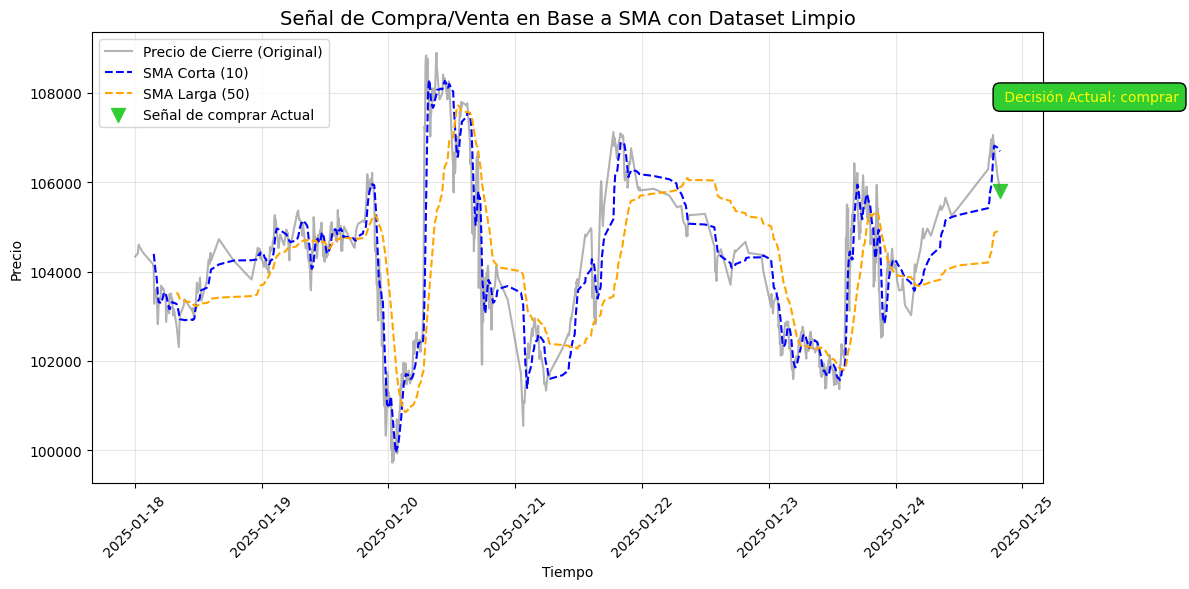

In [ ]:
def graficar_senal_actual():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

  # Configuración del gráfico
  plt.figure(figsize=(12, 6))

  # Gráfica del precio de cierre
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close'], label='Precio de Cierre (Original)', color='gray', alpha=0.6)

  # Gráficas de las medias móviles
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_corto'], label='SMA Corta (10)', linestyle='--', color='blue')
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_largo'], label='SMA Larga (50)', linestyle='--', color='orange')

  # Obtener los datos para la última decisión
  ultimo_dato = df_bitcoin_limpio.iloc[-1]
  x_ultima = ultimo_dato.name
  y_ultima = ultimo_dato['Close']

  # Añadir una anotación con la decisión actual
  plt.scatter(x_ultima, y_ultima, color=color, s=100, label=f'Señal de {algoritmo_decision} Actual', marker='v')
  plt.text(x_ultima, y_ultima+2000, f" Decisión Actual: {algoritmo_decision}", fontsize=10,
            color='yellow', bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.5'))

  # Configuración de etiquetas y título
  plt.title('Señal de Compra/Venta en Base a SMA con Dataset Limpio', fontsize=14)
  plt.xlabel('Tiempo')
  plt.ylabel('Precio')
  plt.legend()
  plt.grid(alpha=0.3)

  # Rotar etiquetas del eje X
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Mostrar el gráfico
  plt.show()

# Llamar a la función para graficar
graficar_senal_actual()

# 6. Ciclo Automatizado

[*********************100%***********************]  1 of 1 completed

[***********************] Iniciando ciclo de análisis...


Número inicial de datos: 1992
Duplicados eliminados: 0
Límites de eliminación de outliers: Inferior=98764.73828125, Superior=108898.51953125
Número final de datos: 893
Datos eliminados durante la limpieza: 1099
Decisión: comprar
Precio Actual: $104678.61
Tendencia: Alta
SMA Corto: 106693.87
SMA Largo: 104938.66


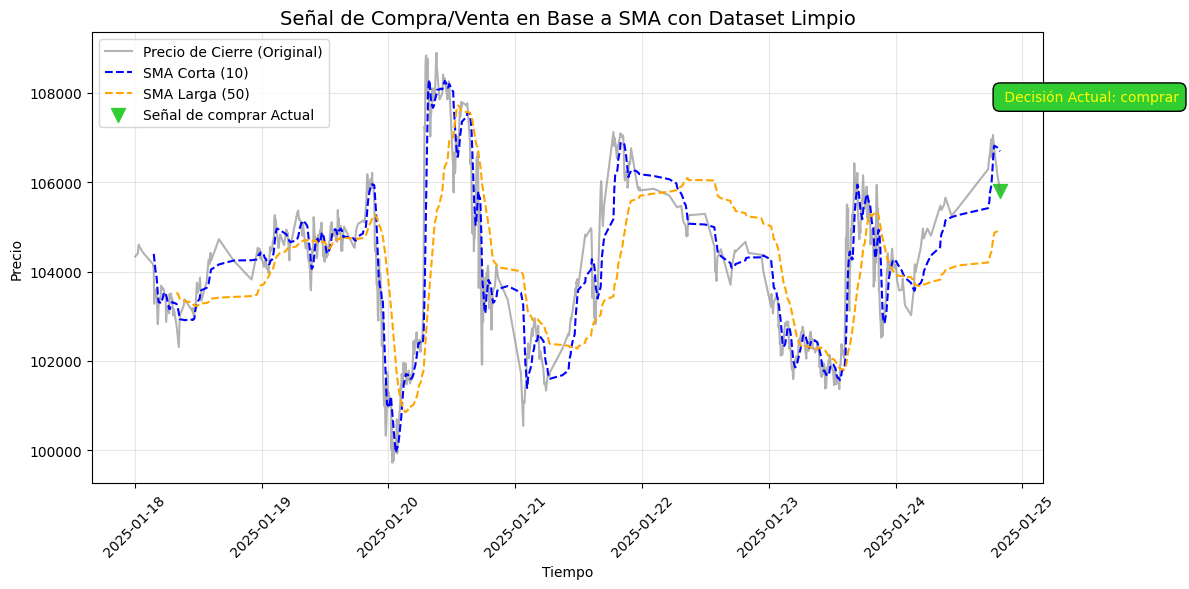

Esperando 5 minutos antes de la siguiente decisión...
Ejecución detenida.


In [ ]:
while True:
  try:
      clear_output(wait=True)  # Limpia la salida anterior
      print("[***********************] Iniciando ciclo de análisis...")

      # Llamada a las funciones
      importar_base_bitcoin()
      extraer_tendencias()
      limpieza_datos()
      calcular_sma()
      tomar_decisiones()
      graficar_senal_actual()

      print("Esperando 5 minutos antes de la siguiente decisión...")
      time.sleep(300)  # Esperamos 5 minutos (300 segundos)
  except KeyboardInterrupt:
      print("Ejecución detenida.")
      break
